In [1]:
# useful to autoreload the module without restarting the kernel
%load_ext autoreload
%autoreload 2

In [2]:
from mppi import InputFiles as I, Calculators as C, Datasets as D, Parsers as P, Utilities as U
from mppi.Utilities import Tools
from mppi.Datasets import PostProcessing as PP
from mppi.Utilities import Constants as Const
from mppi.Utilities import LatticeUtils as LL
import matplotlib.pyplot as plt
import numpy as np
import os, yaml
#import pybinding as pb

In [4]:
# RunRules for local computations
mpi = 4
omp = 2

rr = C.RunRules(omp_num_threads=omp,mpi=mpi)
code = C.QeCalculator(rr)
code.global_options()

Initialize a QuantumESPRESSO calculator with scheduler direct


{'scheduler': 'direct',
 'mpi': 4,
 'omp_num_threads': 2,
 'executable': 'pw.x',
 'skip': True,
 'clean_restart': True,
 'dry_run': False,
 'wait_end_run': True,
 'activate_BeeOND': False,
 'verbose': True}

In [ ]:
# RunRules for ismhpc
# The product of ntasks_per_node*cpus_per_task is equal to 32. 
# Many mpi are needed for better performances
nodes = 1
ntasks_per_node = 16
cpus_per_task=2
omp_num_threads=2

ntasks = nodes*ntasks_per_node

rr = C.RunRules(scheduler='slurm',partition='all12h',
                memory='125000',time='11:59:00',
                nodes=nodes,ntasks_per_node=ntasks_per_node,
                cpus_per_task=cpus_per_task,
                omp_num_threads=omp_num_threads)
code = C.QeCalculator(rr,activate_BeeOND=True) #,skip=False,clean_restart=False
#code.global_options()

In [5]:
# RunRules for m100
nodes = 1
ntasks_per_node = 4
cpus_per_task=32
omp_num_threads=8
gpus_per_node=4
pe=8

ntasks = nodes*ntasks_per_node

rr = C.RunRules(scheduler='slurm',partition='m100_usr_prod',
                account='IscrC_AlNWS2',
                memory='120GB',time='23:59:00',
                nodes=nodes,ntasks_per_node=ntasks_per_node,
                cpus_per_task=cpus_per_task,omp_num_threads=omp_num_threads,
                gpus_per_node=gpus_per_node,pe=pe,
                map_by='socket',rank_by='core')
code = C.QeCalculator(rr)
#code.global_options()

# DFT analysis of the 2D MoS$_2$

This notebook contains the DFT analysis of the 2D MoS$_2$ performed with QuantumESPRESSO

## Lattice properties and atomic positions

We use the lattice configuration adopted by QuantumESPRESSO in the ibrav=4 case.

The basis vector of the (direct) lattice are defined as
$$
a_1 = a_{lat}(1,0,0) \, ,\quad a_2 = a_{lat}(\frac{-1}{2},\frac{\sqrt{3}}{2},0) \, ,\quad
a_3 = a_{lat}(0,0,\frac{c}{a_{lat}})
$$
so that $c$ vacuum space between two replica of the sheets, expressed in the same units as $a_{lat}$.
We also observe that $\textrm{celldm(3)}=c/a_{lat}$, so it expresses the vacuum distance in terms of 
$a_{lat}$.

The cartesian component of the reciprocal lattice vectors (in units of $2\pi/a_{alat}$) are given by:

$$
b_1 = (1,\frac{1}{\sqrt{3}}) \, ,\quad b_2 = (0,\frac{2}{\sqrt{3}},0) \, ,\quad
b_3 = (0,0,\frac{a}{c})
$$
The reciprocal vectors have module $2/\sqrt{3}$.

The cartesian coordinates of the high symmetry points of the reciprocal lattice (in units of $2\pi/a_{alat}$) 
can be determined by performing the construction of the Brillouin zone: we find the points on at the half of
the $b_1$ and $b_2$ vectors and build the path moving perpendicularly to the basis vector directions.
The $M$ point (at the middle of the hexagon face) and the $K$ point (the edge point) are given by:
$$
M = (\frac{1}{2},\frac{1}{2\sqrt{3}}) \, \quad
K = (\frac{2}{3},0) 
$$
Moreover we write the coordinates of the symmetry related K' point (which corresponds to another edge of the hexagon)
and M' point (middle point of the top edge of the hexagon): 
$$
K' = (\frac{1}{3},\frac{1}{\sqrt{3}}) \, \quad
M' = (0,\frac{1}{\sqrt{3}}) 
$$
These points, together with $\Gamma$ define the IBZ edges in the representation of QuantumESPRESSO.

In cartesian coordinates the atomic positions read
$$
Mo = a_{lat}(0,\frac{1}{\sqrt{3}},0) \, \qquad S_1 = a_{lat}(\frac{1}{2},\frac{1}{2\sqrt{3}},\delta) \, \quad
S_2 = a_{lat}(\frac{1}{2},\frac{1}{2\sqrt{3}},-\delta)
$$
where $\delta$ is the buckling of the $S$ atoms in units of $a_{lat}$. Converted in crystal coordinates the atomic positions read
$$
Mo_{cryst} = (\frac{1}{3},\frac{2}{3},0) \, \qquad S_{1-cryst} = (\frac{2}{3},\frac{1}{3},\delta_{cryst}) \, \quad
S_{2-cryst} = (\frac{2}{3},\frac{1}{3},-\delta_{cryst})
$$
where $\delta = (c/a_{lat})\delta_{cryst}$, so the cartesian buckling is equal to the crystal one multiplied times celldm(3).

## GS Analysis

We analyze the electronic configuration of the GS.

In [5]:
pseudo_dir = '../pseudos'
Mo_pseudo = 'Mo-fr.out'
S_pseudo = 'S-fr.out'

According to the results provided by Fulvio Paleari the converged atomic positions read 

In [6]:
alat = 5.9000811881 # in a.u. (Bohr)
c = 40.0 # vacuum distance in a.u. 
celldm3 = c/alat # in units of alat
delta_cryst = 0.073413577 # buckling in crystal coordinates
delta = celldm3*delta_cryst

#kpoints = [12,12,1]
#ecut_wf = 140.0 # energy cutoff of the wfs in Ry

Atomic positions in cartesian and crystal coordinates and lattice vectors

In [7]:
# cartesian coordinates expressed in units of alat
Mo_cart = np.array([0,1./np.sqrt(3.),0.])
S1_cart = np.array([1./2.,1./(2*np.sqrt(3.)),delta])
S2_cart = np.array([1./2.,1./(2*np.sqrt(3.)),-delta])

Mo_cryst = np.array([1./3.,2./3.,0.])
S1_cryst = np.array([2./3.,1./3.,delta_cryst])
S2_cryst = np.array([2./3.,1./3.,-delta_cryst])

lattice = alat*np.array([[1,0,0],[-1./2.,np.sqrt(3)/2.,0],[0,0,celldm3]])
atoms = [['Mo',alat*Mo_cart],['S',alat*S1_cart],['S',alat*S2_cart]]

We plot the lattice in xy and xz directions

In [8]:
positions = LL.build_lattice(lattice,atoms,8,8,1)
#positions

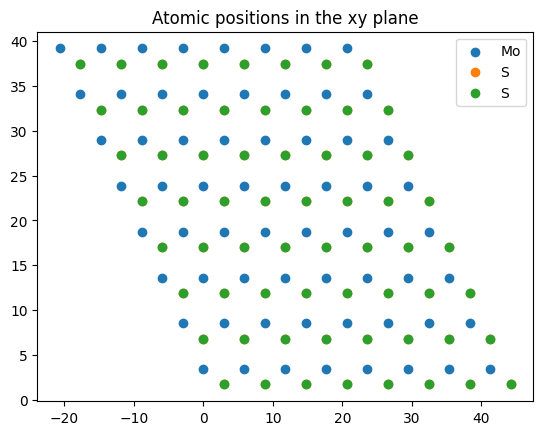

In [13]:
for pos in positions:
    plt.scatter(pos[1],pos[2],label=pos[0])
plt.title('Atomic positions in the xy plane',size=12)
plt.legend()

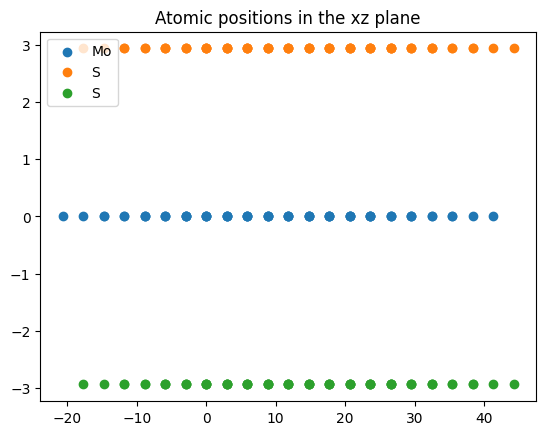

In [14]:
for pos in positions:
    plt.scatter(pos[1],pos[3],label=pos[0])
plt.title('Atomic positions in the xz plane',size=12)
plt.legend()

### Convergence procedure on the $k$-points sampling and of energy cutoff of the wave functions

We perform a set of calculations in functions of the number of k-points and of the energy cutoff and we find
the converged values using the total ground state energy and the gap at $K$ as control quantities.

In [15]:
run_dir = 'DFT_analysis'

We build the basic elements of the input 

In [17]:
#prefix = 'gs_analysis'

inp = I.PwInput()
inp.set_scf(force_symmorphic=True,conv_thr=1e-6)
#inp.set_prefix(prefix)
inp.set_num_bnds(28)
inp.set_pseudo_dir(pseudo_dir=pseudo_dir)
inp.set_spinorbit()
inp.add_atom(atom='Mo',pseudo_name=Mo_pseudo,mass=42.00)
inp.add_atom(atom='S',pseudo_name=S_pseudo,mass=16.00)
inp.set_atoms_number(3)
inp.set_atomic_positions([['Mo',Mo_cart],['S',S1_cart],['S',S2_cart]],type='alat')
#inp.set_atomic_positions([['Mo',Mo_cryst],['S',S1_cryst],['S',S2_cryst]],type='crystal')
inp.set_lattice(ibrav=4,celldm1=alat,celldm3=celldm3)
#inp.set_kpoints(type='automatic',points=kpoints)
#inp.set_energy_cutoff(ecut_wf)
inp

{'control': {'calculation': "'scf'",
  'verbosity': "'high'",
  'prefix': "'pwscf'",
  'outdir': "'./'",
  'pseudo_dir': "'../pseudos'"},
 'system': {'force_symmorphic': '.true.',
  'nbnd': 28,
  'lspinorb': '.true.',
  'noncolin': '.true.',
  'ntyp': '2',
  'nat': '3',
  'ibrav': 4,
  'celldm(1)': 5.9000811881,
  'celldm(3)': 6.779567725386027},
 'electrons': {'diago_full_acc': '.false.', 'conv_thr': 1e-06},
 'ions': {},
 'cell': {},
 'atomic_species': {'Mo': [42.0, 'Mo-fr.out'], 'S': [16.0, 'S-fr.out']},
 'atomic_positions': {'type': 'alat',
  'values': [['Mo', array([0.        , 0.57735027, 0.        ])],
   ['S', array([0.5       , 0.28867513, 0.49771232])],
   ['S', array([ 0.5       ,  0.28867513, -0.49771232])]]},
 'kpoints': {},
 'cell_parameters': {}}

In [37]:
kvalues = [12,15]
ecut = [40,60,80,100,120] #[60,80,100]

In [42]:
study = D.Dataset(run_dir=run_dir,num_tasks=4)

for k in kvalues:
    for e in ecut:
        idd = {'ecut' : e, 'k' : k}
        inp.set_prefix(D.name_from_id(idd))
        inp.set_kpoints(type='automatic',points=[k,k,1])
        inp.set_energy_cutoff(e)
        study.append_run(id=idd,input=inp,runner=code)
    
study.set_postprocessing_function(PP.pw_parse_data)

Initialize a Dataset with 4 parallel tasks


In [43]:
results = study.run()

Run the selection [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] with the parallel task_groups [[0, 1, 2, 3], [4, 5, 6, 7], [8, 9]] 

Run the task [0, 1, 2, 3] 
Skip the run of ecut_40-k_12Skip the run of
 ecut_60-k_12Skip the run of
 ecut_80-k_12
Skip the run of ecut_100-k_12
Task [0, 1, 2, 3] ended 
 
Run the task [4, 5, 6, 7] 
Skip the run of ecut_120-k_12
Skip the run of ecut_40-k_15
Skip the run of ecut_60-k_15
Skip the run of ecut_80-k_15
Task [4, 5, 6, 7] ended 
 
Run the task [8, 9] 
Skip the run of ecut_100-k_15
Skip the run of ecut_120-k_15
Task [8, 9] ended 
 


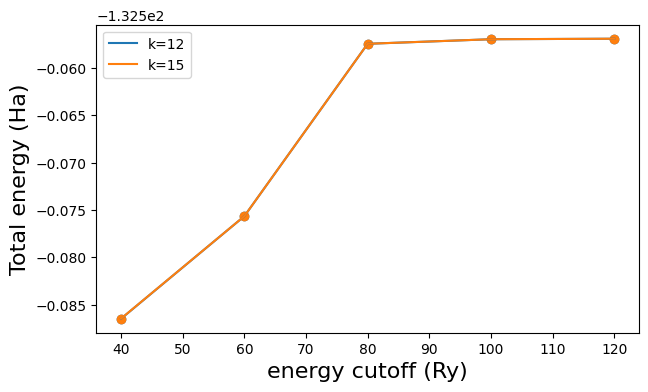

In [47]:
plt.figure(figsize=(7,4))
plt.xlabel('energy cutoff (Ry)',size=16)
plt.ylabel('Total energy (Ha)',size=16)
for k in kvalues:
    energy =study.fetch_results(id={'k':k},attribute='energy')
    plt.plot(ecut,energy,label='k=%s'%k)
    plt.scatter(ecut,energy)
plt.legend()

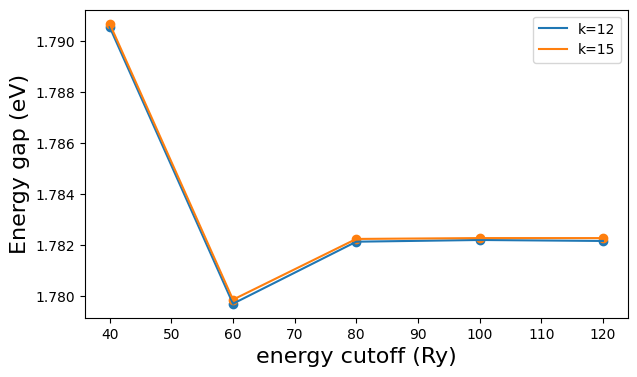

In [48]:
plt.figure(figsize=(7,4))
plt.xlabel('energy cutoff (Ry)',size=16)
plt.ylabel('Energy gap (eV)',size=16)
for k in kvalues:
    data = study.fetch_results(id={'k':k})    
    gap = [d.get_gap(verbose=False)['gap'] for d in data]
    plt.plot(ecut,gap,label='k=%s'%k)
    plt.scatter(ecut,gap)
plt.legend()

On the basis of these results we choose

In [8]:
ecut_conv = 80 # energy cutoff on the wavefunction (Ry)
kpoints_conv = [12,12,1]

In [9]:
inp.set_energy_cutoff(ecut_conv)
inp.set_kpoints(type='automatic',points=kpoints_conv)

### Calculation of the equilibrium lattice constants and buckling parameter

We determine the equiblrium values of the lattice constant and of the buckling parameter by minimizing
the GS energy

In [18]:
alat_range = 2 # alat percentage variation
alat_num = 5 # number of calculations
delta_range = 2 # buckling percentage variation
delta_num = 5 # number of calculations

alat_span = np.linspace(-alat_range/2,alat_range/2,alat_num)

delta_span = np.linspace(-delta_range/2,delta_range/2,delta_num)

alat_span, delta_span

(array([-1.5, -1. , -0.5,  0. ,  0.5,  1. ,  1.5]),
 array([-1.5, -1. , -0.5,  0. ,  0.5,  1. ,  1.5]))

In [19]:
study = D.Dataset(run_dir=run_dir,num_tasks=10)

for a_span in alat_span:
    for d_span in delta_span:
        a = alat*(1+a_span/100)
        d = delta*(1+d_span/100)
        A = np.array([0,0,d])
        B = np.array([0,1/np.sqrt(3),-d])
        idd = {'alat' : a_span, 'delta' : d_span}
        inp.set_prefix(D.name_from_id(idd))
        inp.set_atomic_positions([['Ge',A],['Ge',B]],type='alat')
        inp.set_lattice(ibrav=4,celldm1=a,celldm3=c)
        study.append_run(id=idd,input=inp,runner=code)
    
study.set_postprocessing_function(PP.pw_get_energy)
#study.set_postprocessing_function(PP.pw_parse_data)

Initialize a Dataset with 10 parallel tasks


In [ ]:
results = study.run()

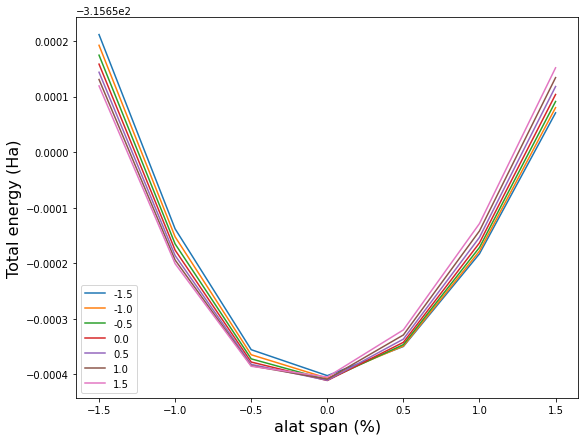

In [21]:
plt.figure(figsize=(9,7))
plt.xlabel('alat span (%)',size=16)
plt.ylabel('Total energy (Ha)',size=16)
for d_span in delta_span:
    energy =study.fetch_results(id={'delta':d_span})
    plt.plot(alat_span,energy,label=d_span)
plt.legend()

To find the optimal alat parameter we perform a quadratic fit of data (for delta=0)

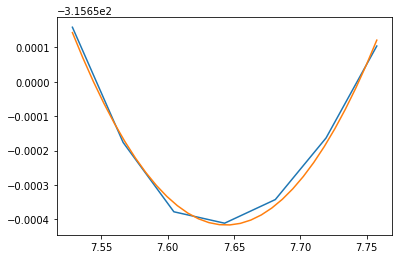

In [22]:
y =study.fetch_results(id={'delta':0.})
x = [alat*(1+a/100) for a in alat_span]
x_fit = np.linspace(x[0],x[-1],30)
coeffs = np.polyfit(x,y,2)
y_fit = [coeffs[0]*xx**2+coeffs[1]*xx+coeffs[2] for xx in x_fit]
plt.plot(x,y)
plt.plot(x_fit,y_fit)

In [ ]:
x_eq = -coeffs[1]/(2*coeffs[0])
x_eq

In substantial agreement with the value already provided in the input.

In the same way the optimal buckling is 

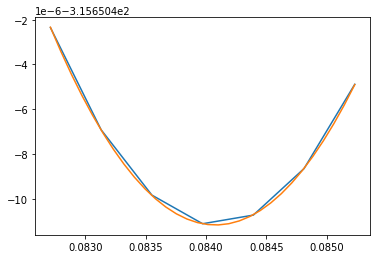

In [24]:
y =study.fetch_results(id={'alat':0.})
x = [delta*(1+a/100) for a in delta_span]
x_fit = np.linspace(x[0],x[-1],30)
coeffs = np.polyfit(x,y,2)
y_fit = [coeffs[0]*xx**2+coeffs[1]*xx+coeffs[2] for xx in x_fit]
plt.plot(x,y)
plt.plot(x_fit,y_fit)

In [ ]:
x_eq = -coeffs[1]/(2*coeffs[0])
x_eq

We perform a last scf calculation with the converged parameters

In [10]:
alat_conv = 7.6441
delta_conv = 0.0841

A = np.array([0,0,delta_conv])
B = np.array([0,1./np.sqrt(3),-delta_conv])

In [11]:
study = D.Dataset(run_dir=run_dir,num_tasks=1)

idd = 'gs_converged'
inp.set_prefix(D.name_from_id(idd))
inp.set_atomic_positions([['Ge',A],['Ge',B]],type='alat')
inp.set_lattice(ibrav=4,celldm1=alat_conv,celldm3=c)
study.append_run(id=idd,input=inp,runner=code)
    
study.set_postprocessing_function(PP.pw_parse_data)

Initialize a Dataset with 1 parallel tasks


In [14]:
study.runs

[{'label': 'Dataset',
  'run_dir': 'DFT_analysis-vac_4',
  'num_tasks': 1,
  'verbose': True,
  'input': {'control': {'calculation': "'scf'",
    'verbosity': "'high'",
    'prefix': "'gs_converged'",
    'outdir': "'./'",
    'pseudo_dir': "'../pseudos'"},
   'system': {'force_symmorphic': '.true.',
    'nbnd': 32,
    'lspinorb': '.true.',
    'noncolin': '.true.',
    'ntyp': '1',
    'nat': '2',
    'ibrav': 4,
    'celldm(1)': 7.6441,
    'celldm(3)': 4.0,
    'ecutwfc': 50},
   'electrons': {'diago_full_acc': '.false.', 'conv_thr': 1e-06},
   'ions': {},
   'cell': {},
   'atomic_species': {'Ge': [72.64, 'Ge.rel-pbe-dn-kjpaw_psl.0.2.2.UPF']},
   'atomic_positions': {'type': 'alat',
    'values': [['Ge', array([0.    , 0.    , 0.0841])],
     ['Ge', array([ 0.        ,  0.57735027, -0.0841    ])]]},
   'kpoints': {'type': 'automatic', 'values': ([18, 18, 1], [0.0, 0.0, 0.0])},
   'cell_parameters': {}},
  'name': 'gs_converged'}]

In [15]:
results = study.run()

Run the selection [0] with the parallel task_groups [[0]] 

Run the task [0] 
create the run_dir folder : 'DFT_analysis-vac_4'
run command: mpirun -np 32 pw.x -inp gs_converged.in > gs_converged.log
slurm submit:  cd DFT_analysis-vac_4 ; sbatch job_gs_converged.sh
computation gs_converged is running...
computation gs_converged ended
Task [0] ended 
 


In [16]:
results[0].get_gap()

Direct gap system
Gap : 0.024156505631320435 eV


{'gap': 0.024156505631320435,
 'direct_gap': 0.024156505631320435,
 'position_cbm': 36,
 'positon_vbm': 36}

The Gap (as given by the scf computation) with celldm3=6 is equal to 0.024154 eV.

In [26]:
kp = results[0].kpoints # cartesian coordinates in units of 2\pi/alat
kp[-1]

array([0.33333333, 0.57735027, 0.        ])

In [ ]:
######################################################################################

We build the input

In [92]:
prefix = 'gs_analysis'

inp = I.PwInput()
inp.set_scf(force_symmorphic=True,conv_thr=1e-6)
inp.set_prefix(prefix)
#inp.set_num_bnds(32)
inp.set_pseudo_dir(pseudo_dir=pseudo_dir)
inp.set_spinorbit()
inp.add_atom(atom='Mo',pseudo_name=Mo_pseudo,mass=42.00)
inp.add_atom(atom='S',pseudo_name=S_pseudo,mass=16.00)
inp.set_atoms_number(3)
inp.set_atomic_positions([['Mo',Mo_cryst],['S',S1_cryst],['S',S2_cryst]],type='crystal')
inp.set_lattice(ibrav=4,celldm1=alat,celldm3=celldm3)
inp.set_kpoints(type='automatic',points=kpoints)
inp.set_energy_cutoff(ecut_wf)
inp

{'control': {'calculation': "'scf'",
  'verbosity': "'high'",
  'prefix': "'gs_analysis'",
  'outdir': "'./'",
  'pseudo_dir': "'../pseudos'"},
 'system': {'force_symmorphic': '.true.',
  'lspinorb': '.true.',
  'noncolin': '.true.',
  'ntyp': '2',
  'nat': '3',
  'ibrav': 4,
  'celldm(1)': 5.9000811881,
  'celldm(3)': 6.779567725386027,
  'ecutwfc': 140.0},
 'electrons': {'diago_full_acc': '.false.', 'conv_thr': 1e-06},
 'ions': {},
 'cell': {},
 'atomic_species': {'Mo': [42.0, 'Mo-fr.out'], 'S': [16.0, 'S-fr.out']},
 'atomic_positions': {'type': 'crystal',
  'values': [['Mo', array([0.33333333, 0.66666667, 0.        ])],
   ['S', array([0.66666667, 0.33333333, 0.07341358])],
   ['S', array([ 0.66666667,  0.33333333, -0.07341358])]]},
 'kpoints': {'type': 'automatic', 'values': ([12, 12, 1], [0.0, 0.0, 0.0])},
 'cell_parameters': {}}

And we run the computation

In [35]:
run_dir = 'GS'

In [36]:
code.run(input=inp,run_dir=run_dir,name=prefix)

delete log file: GS/gs_analysis.log
run command: mpirun -np 4 pw.x -inp gs_analysis.in > gs_analysis.log
computation gs_analysis is running...


Note: The following floating-point exceptions are signalling: IEEE_DENORMAL
Note: The following floating-point exceptions are signalling: IEEE_DENORMAL
Note: The following floating-point exceptions are signalling: IEEE_DENORMAL
Note: The following floating-point exceptions are signalling: IEEE_DENORMAL


computation gs_analysis ended


'/home/marco/Data/RICERCA/DFT AND MANY BODY/2D ELECTRONIC AND OPTICAL PROPERTIES/MoS2/GS/gs_analysis.save/data-file-schema.xml'

In [6]:
results = P.PwParser('GS/gs_analysis.save/data-file-schema.xml')

Parse file : GS/gs_analysis.save/data-file-schema.xml


In [7]:
results.get_energy()

-3607.059776988414

In [23]:
3607/27.23

132.4641939037826

## NSCF computations on regular grids